# TWEET STANCE CLASSIFIER

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
from transformers import modelcard

from models.transfomer_stance_classifier import StanceClassifier

/opt/homebrew/anaconda3/envs/tensorflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/homebrew/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebre

In [2]:
EPOCH = 3

# Helper functions

In [3]:
def plot_history(history):
    plt.plot(history.Epoch, history["Training Loss"], label='train_loss')
    plt.plot(history.Epoch, history["Validation Loss"], label='val_loss')

    plt.legend()
    plt.xticks(history.Epoch)
    plt.xlabel('Epoch')
    plt.ylabel("loss")
    plt.grid(True)

In [4]:
def evaluate(test_stances, test_targets, test_preds, model_name):
    df = pd.DataFrame({"Stance": test_stances, "Target": test_targets, "preds": test_preds})

    f1_per_stance = f1_score(test_stances, test_preds, average=None)

    metrics = df.groupby("Target").apply(lambda row: f1_score(row["Stance"], row["preds"], average="macro")).to_dict()

    for stance, f1 in zip(["AGAINST", "FAVOR", "NONE"], f1_per_stance):
        metrics[stance] = f1

    metrics["overall"] = f1_score(test_stances, test_preds, average="macro")
    
    return pd.DataFrame(metrics, index=[model_name])

In [5]:
def plot_confusion_matrix(test_stances, test_preds, class_names=["AGAINST", "FAVOR", "NONE"], 
                          title="Confusion Matrix for Stance Detection\n\n"):
    cf_matrix = confusion_matrix(test_stances, test_preds)
    plt.figure(figsize=(5,4))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.0f')

    ax.set_title(title);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values');

    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [6]:
def print_report(classifier, test_texts, test_targets, test_stances, model_name, 
                 class_names=["AGAINST", "FAVOR", "NONE"], cm_title="Confusion Matrix for Stance Detection\n\n"):
    history = pd.DataFrame(modelcard.parse_log_history(classifier.trainer.state.log_history)[1])
    plot_history(history)
    
    preds = pd.DataFrame(classifier.predict(test_texts, test_targets)).label.str.split("_").str[1].astype(int)
    eval_df = evaluate(test_stances, test_targets, preds, model_name)
    display(eval_df)
    
    plot_confusion_matrix(test_stances, preds)
    
    return eval_df

## Data Overview

In [7]:
train_dir = 'data/StanceDataset/train.csv'
test_dir = 'data/StanceDataset/test.csv'

In [8]:
from charset_normalizer import detect
# Detect the encoding
with open(train_dir, "rb") as f:
    detected_encoding = detect(f.read())["encoding"]

In [9]:
train_df = pd.read_csv(train_dir, encoding=detected_encoding, engine='python', on_bad_lines='skip')
test_df = pd.read_csv(test_dir, encoding=detected_encoding, engine='python', on_bad_lines='skip')

In [10]:
train_df.columns

Index(['Tweet', 'Target', 'Stance', 'Opinion Towards', 'Sentiment'], dtype='object')

In [11]:
train_df, val_df = train_test_split(train_df, random_state=42)

In [12]:
train_df.reset_index(inplace=True)

In [13]:
val_df.reset_index(inplace=True)

## Data Preprocess 

In [14]:
train_texts = train_df['Tweet']
train_targets = train_df['Target']
train_stances = train_df['Stance'].replace({"AGAINST": 0, "FAVOR": 1, "NONE": 2})

/var/folders/59/y8807kwj75nfp1r9n0zrnk7h0000gn/T/ipykernel_19291/3141071828.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_stances = train_df['Stance'].replace({"AGAINST": 0, "FAVOR": 1, "NONE": 2})


In [15]:
test_texts = test_df['Tweet']
test_targets = test_df['Target']
test_stances = test_df['Stance'].replace({"AGAINST": 0, "FAVOR": 1, "NONE": 2})

/var/folders/59/y8807kwj75nfp1r9n0zrnk7h0000gn/T/ipykernel_19291/3119419252.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_stances = test_df['Stance'].replace({"AGAINST": 0, "FAVOR": 1, "NONE": 2})


In [16]:
val_texts = val_df['Tweet']
val_targets = val_df['Target']
val_stances = val_df['Stance'].replace({"AGAINST": 0, "FAVOR": 1, "NONE": 2})

/var/folders/59/y8807kwj75nfp1r9n0zrnk7h0000gn/T/ipykernel_19291/4105632397.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_stances = val_df['Stance'].replace({"AGAINST": 0, "FAVOR": 1, "NONE": 2})


## Modelling

### roberta-base

In [17]:
MODEL_NAME_1 = "roberta-base"

In [18]:
classifier = StanceClassifier(MODEL_NAME_1)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
classifier.train(
    train_texts= train_texts,
    train_targets=train_targets,
    train_stances=train_stances,
    val_texts = val_texts,
    val_targets=val_targets,
    val_stances=val_stances,
    num_epochs=EPOCH
)

Epoch,Training Loss,Validation Loss,F1
1,0.902700,0.810204,0.652466
2,0.675500,0.713478,0.678462
3,0.469800,0.734955,0.710620


Device set to use mps:0
/var/folders/59/y8807kwj75nfp1r9n0zrnk7h0000gn/T/ipykernel_19291/19166642.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = df.groupby("Target").apply(lambda row: f1_score(row["Stance"], row["preds"], average="macro")).to_dict()


,Atheism,Climate Change is a Real Concern,Donald Trump,Feminist Movement,Hillary Clinton,Legalization of Abortion,AGAINST,FAVOR,NONE,overall
roberta-base,0.704239,0.544988,0.320403,0.59054,0.712852,0.631422,0.670342,0.547445,0.597179,0.604989


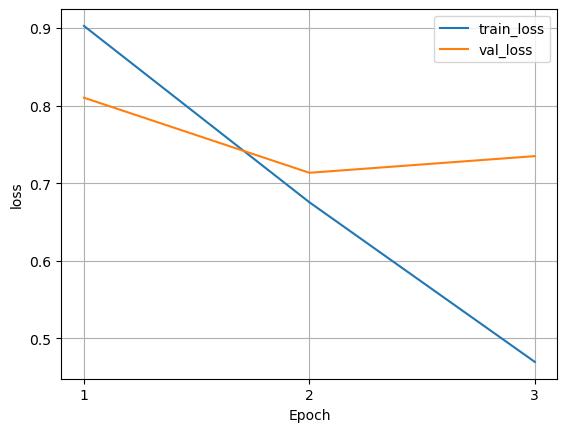

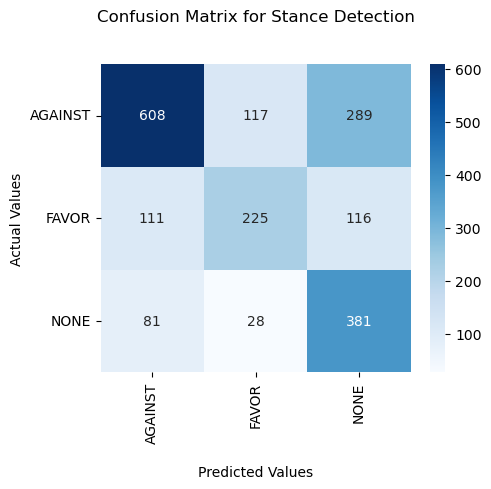

In [20]:
eval_df1 = print_report(classifier, test_texts, test_targets, test_stances, MODEL_NAME_1)

### bertweet

In [21]:
MODEL_NAME_2 = "vinai/bertweet-base"

In [22]:
classifier = StanceClassifier(MODEL_NAME_2)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
classifier.train(
    train_texts= train_texts,
    train_targets=train_targets,
    train_stances=train_stances,
    val_texts = val_texts,
    val_targets=val_targets,
    val_stances=val_stances,
)

Epoch,Training Loss,Validation Loss,F1
1,0.941100,0.799373,0.618763
2,0.669100,0.801037,0.643658
3,0.451900,0.737132,0.708706


Device set to use mps:0
/var/folders/59/y8807kwj75nfp1r9n0zrnk7h0000gn/T/ipykernel_19291/19166642.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = df.groupby("Target").apply(lambda row: f1_score(row["Stance"], row["preds"], average="macro")).to_dict()


,Atheism,Climate Change is a Real Concern,Donald Trump,Feminist Movement,Hillary Clinton,Legalization of Abortion,AGAINST,FAVOR,NONE,overall
vinai/bertweet-base,0.624949,0.556484,0.382736,0.596088,0.709986,0.588406,0.67411,0.536928,0.621392,0.61081


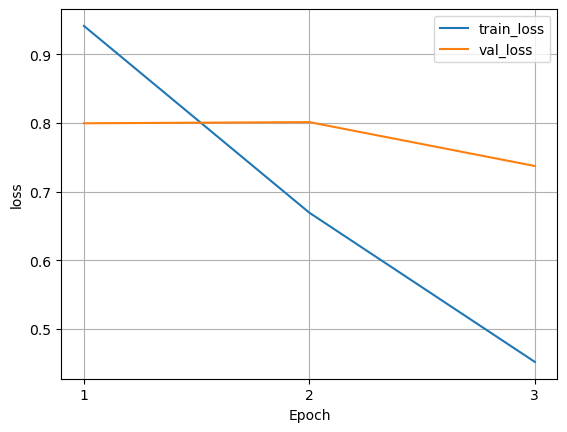

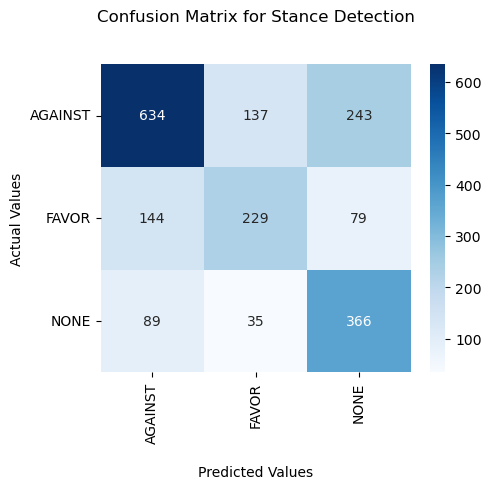

In [24]:
eval_df2 = print_report(classifier, test_texts, test_targets, test_stances, MODEL_NAME_2)

### bert-base-uncased

In [25]:
MODEL_NAME_3 = "bert-base-uncased"

In [26]:
classifier = StanceClassifier(MODEL_NAME_3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
classifier.train(
    train_texts= train_texts,
    train_targets=train_targets,
    train_stances=train_stances,
    val_texts = val_texts,
    val_targets=val_targets,
    val_stances=val_stances,
)

Epoch,Training Loss,Validation Loss,F1
1,0.917100,0.798930,0.561773
2,0.651700,0.733657,0.694203
3,0.356500,0.849881,0.680654


Device set to use mps:0
/var/folders/59/y8807kwj75nfp1r9n0zrnk7h0000gn/T/ipykernel_19291/19166642.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = df.groupby("Target").apply(lambda row: f1_score(row["Stance"], row["preds"], average="macro")).to_dict()


,Atheism,Climate Change is a Real Concern,Donald Trump,Feminist Movement,Hillary Clinton,Legalization of Abortion,AGAINST,FAVOR,NONE,overall
bert-base-uncased,0.501817,0.543891,0.304226,0.591609,0.463941,0.606479,0.652243,0.470886,0.542787,0.555305


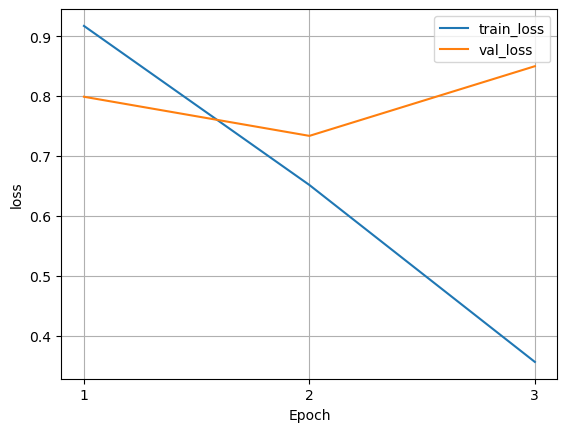

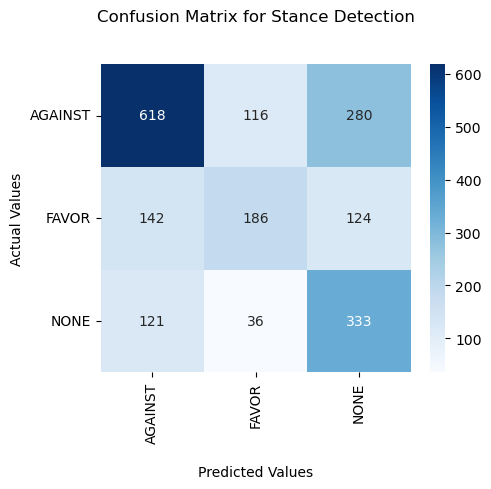

In [28]:
eval_df3 = print_report(classifier, test_texts, test_targets, test_stances, MODEL_NAME_3)

### distilbert-base-cased

In [29]:
MODEL_NAME_4 = "distilbert-base-cased"

In [30]:
classifier = StanceClassifier(MODEL_NAME_4)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
classifier.train(
    train_texts= train_texts,
    train_targets=train_targets,
    train_stances=train_stances,
    val_texts = val_texts,
    val_targets=val_targets,
    val_stances=val_stances,
)

Epoch,Training Loss,Validation Loss,F1
1,0.931400,0.828094,0.565763
2,0.679100,0.768463,0.647806
3,0.442500,0.822676,0.675643


Device set to use mps:0
/var/folders/59/y8807kwj75nfp1r9n0zrnk7h0000gn/T/ipykernel_19291/19166642.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = df.groupby("Target").apply(lambda row: f1_score(row["Stance"], row["preds"], average="macro")).to_dict()


,Atheism,Climate Change is a Real Concern,Donald Trump,Feminist Movement,Hillary Clinton,Legalization of Abortion,AGAINST,FAVOR,NONE,overall
distilbert-base-cased,0.532769,0.508005,0.313649,0.542812,0.552749,0.601123,0.632884,0.491187,0.512438,0.545503


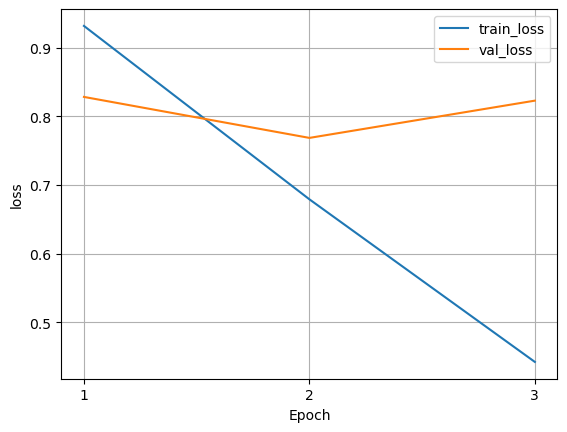

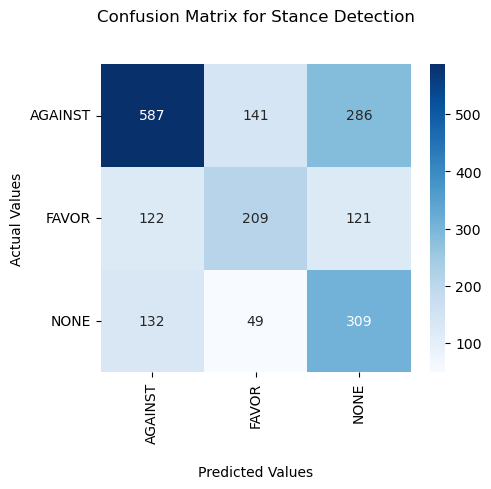

In [32]:
eval_df4 = print_report(classifier, test_texts, test_targets, test_stances, MODEL_NAME_4)

### sentence-transformers/LaBSE

In [33]:
MODEL_NAME_5 = "sentence-transformers/LaBSE"

In [34]:
classifier = StanceClassifier(MODEL_NAME_5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/LaBSE and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
classifier.train(
    train_texts= train_texts,
    train_targets=train_targets,
    train_stances=train_stances,
    val_texts = val_texts,
    val_targets=val_targets,
    val_stances=val_stances,
)

Epoch,Training Loss,Validation Loss,F1
1,0.892100,0.784663,0.642922
2,0.604200,0.758677,0.666395
3,0.338300,0.805523,0.704097


Device set to use mps:0
/var/folders/59/y8807kwj75nfp1r9n0zrnk7h0000gn/T/ipykernel_19291/19166642.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = df.groupby("Target").apply(lambda row: f1_score(row["Stance"], row["preds"], average="macro")).to_dict()


,Atheism,Climate Change is a Real Concern,Donald Trump,Feminist Movement,Hillary Clinton,Legalization of Abortion,AGAINST,FAVOR,NONE,overall
sentence-transformers/LaBSE,0.637611,0.509123,0.37804,0.602776,0.670219,0.588189,0.647619,0.549763,0.583009,0.593464


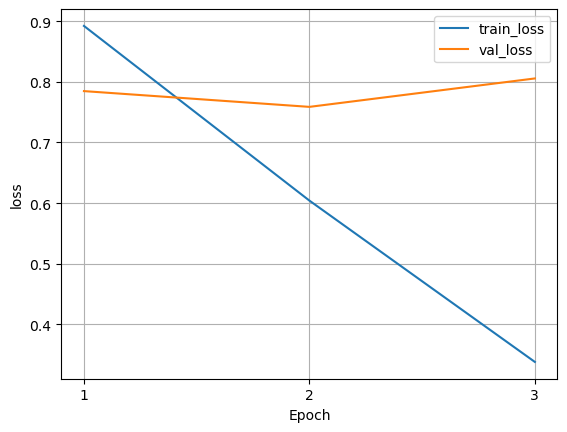

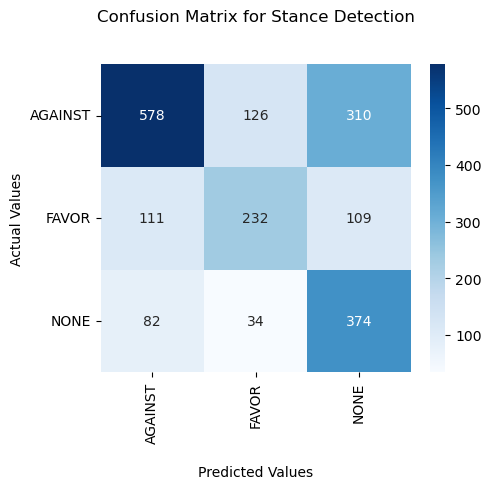

In [36]:
eval_df5 = print_report(classifier, test_texts, test_targets, test_stances, MODEL_NAME_5)

In [37]:
pd.concat([eval_df1, eval_df2, eval_df3, eval_df4, eval_df5])

,Atheism,Climate Change is a Real Concern,Donald Trump,Feminist Movement,Hillary Clinton,Legalization of Abortion,AGAINST,FAVOR,NONE,overall
roberta-base,0.704239,0.544988,0.320403,0.590540,0.712852,0.631422,0.670342,0.547445,0.597179,0.604989
vinai/bertweet-base,0.624949,0.556484,0.382736,0.596088,0.709986,0.588406,0.674110,0.536928,0.621392,0.610810
bert-base-uncased,0.501817,0.543891,0.304226,0.591609,0.463941,0.606479,0.652243,0.470886,0.542787,0.555305
distilbert-base-cased,0.532769,0.508005,0.313649,0.542812,0.552749,0.601123,0.632884,0.491187,0.512438,0.545503
sentence-transformers/LaBSE,0.637611,0.509123,0.378040,0.602776,0.670219,0.588189,0.647619,0.549763,0.583009,0.593464
